In [58]:
%matplotlib inline

Dynamics of a single particle in free space is the simplest kind of simulation. It allows to check basic functionality of the program, and, besides, it is a good way to become familiar with how the program works.

In absence of external forces, a body moves in straight line with constant velocity

\begin{align}
& \textbf{r}(t) = \textbf{r}_0 + \textbf{v}_0 t
\\
& \textbf{v}(t) = \textbf{v}_0
\end{align}

To get some sense of scales (see below), suppose the particle is an electron that has just passed an 1 keV accelerating potential difference. Its mass `m` and charge `q` are `q = 4.8e-10 [cgs], m = 9.1e-28 [g]`. Since its energy is nonrelativistic, it's possible to calculate its speed simply as $v = \sqrt{ 2 E / m } = 1.808e+09 ~ [cm/s]$. To cover a `10 [cm]` distance with such speed, it will take the electron `t = 5.530e-09 [s] ~ 6 [ns]`.

In [59]:
from math import *

m = 9.8e-28
q = 4.8e-10
print( "q = {:.3e} [cgs]".format( q ) )
print( "m = {:.3e} [g]".format( m ) )

ev_to_cgs = 1.60218e-12
E = 1000 * ev_to_cgs
v = sqrt( 2 * E / m )
z = 10
t = z / v
print( "E = {:.3e} [eV] = {:.3e} [erg]".format( E / ev_to_cgs, E ) )
print( "v = {:.3e} [cm/s]; p = {:.3e} [g * cm/s]".format( v, v * m ) )
print( "z = {:.3e} [cm]".format( z ) )
print( "t = {:.3e} [s]".format( t ) )

q = 4.800e-10 [cgs]
m = 9.800e-28 [g]
E = 1.000e+03 [eV] = 1.602e-09 [erg]
v = 1.808e+09 [cm/s]; p = 1.772e-18 [g * cm/s]
z = 1.000e+01 [cm]
t = 5.530e-09 [s]


To perform a simulation, it's necessary to prepare a config file. It is an `ini`-file with sections describing the simulation parameters, e.g.:

```
[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
...
```
If Ef is invoked from the command line, this file is passed as an argument:

```
./ef.out conf.ini
```

The list of supported config sections can be found in the wiki: https://github.com/epicf/ef/wiki/Supported-Config-File-Sections .

Config classes can be used to create, visualize and read/write to ini the config file with python or jupyter.

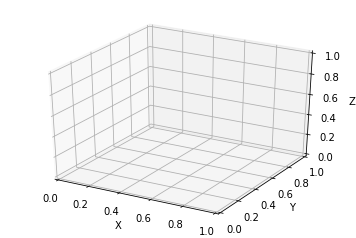

In [60]:
from ef.config.components import *
from ef.config.efconf import EfConf
from ef.config.visualizer import Visualizer3d
Visualizer3d()


First, it's necessary to set a total time of the simulation and a time step.
Let's use the estimates above as guiding values and set the total time to `6e-9 [s]`.
We use `1000` time steps, so that `time_step_size = 6.0e-12 [s]`. 
Besides, it's necessary to decide at which time steps the state of the whole simulation should be saved to the disk.
To save each step, `time_save_step` is set equal to `time_step_size`: `time_save_step = 6.0e-12`.

In [61]:
single_particle_in_free_space_conf = ""

time_grid_sec = """
[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + time_grid_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12



In [62]:
timegrid = TimeGridConf(total=6e-09, save_step=6e-12, step=6e-12)
print(repr(timegrid))
print(timegrid)

TimeGridConf(total=6e-09, save_step=6e-12, step=6e-12)
### TimeGridConf:
total = 6e-09
save_step = 6e-12
step = 6e-12


Next we need to define size of a computational volume.
Domain size is set to 15 [cm] along the z-axis and 5 [cm] along the x- and y-axes. 
The parameters for PIC-mesh are also defined in this section.
Since we are going to use noninteracting particle model instead of PIC, they are not used and can be set arbitrary. 

In [63]:
spat_mesh_sec = """
[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + spat_mesh_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5



SpatialMeshConf(size=array([ 5.,  5., 15.]), step=array([0.5, 0.5, 1.5]))
### SpatialMeshConf:
size = array([ 5.,  5., 15.])
step = array([0.5, 0.5, 1.5])


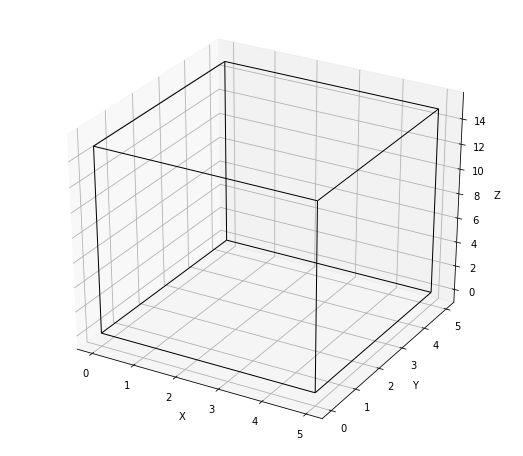

In [64]:
mesh = SpatialMeshConf((5, 5, 15), (.5, .5, 1.5))
print(repr(mesh))
print(mesh)
Visualizer3d().visualize([mesh])


Next, a particle source. 
We need a single particle at startup ( `initial_number_of_particles = 1` ), approximately 1 [mm] away from
coordinate axis origin at the bottom-left-near corner of the domain (`shape = Box( origin = (0.1, ...` below and `box_x_left = 0.10 ...` in the ini-version).
Charge and mass are set to those of the electron.
Momentum corresponding to 1 keV energy is `1.772e-18 [g * cm / s]`.
Such value is set for momentum along the z-axis. 
Momenta along the x- and y-axes could be set to zero; instead they are chosen 3 times smaller than the z-axis momentum
(domain size along the x and y is 3 times smaller than along the z). 
To prevent any variation in momentum, the `temperature` is set to 0.
Notice that the source is given a descriptive name: `emit_single_particle` in this case.

In [65]:
emit_single_particle_sec = """
[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + emit_single_particle_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28



ParticleSourceConf(name='emit_single_particle', shape=Box(origin=array([0.1, 0.1, 0.1]), size=array([0.01, 0.01, 0.01])), initial_particles=1, particles_to_generate_each_step=0, momentum=array([6.00e-19, 6.00e-19, 1.77e-18]), temperature=0.0, charge=4.8e-10, mass=9.8e-28)
### ParticleSourceConf:
name = 'emit_single_particle'
shape = Box(origin=array([0.1, 0.1, 0.1]), size=array([0.01, 0.01, 0.01]))
initial_particles = 1
particles_to_generate_each_step = 0
momentum = array([6.00e-19, 6.00e-19, 1.77e-18])
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28


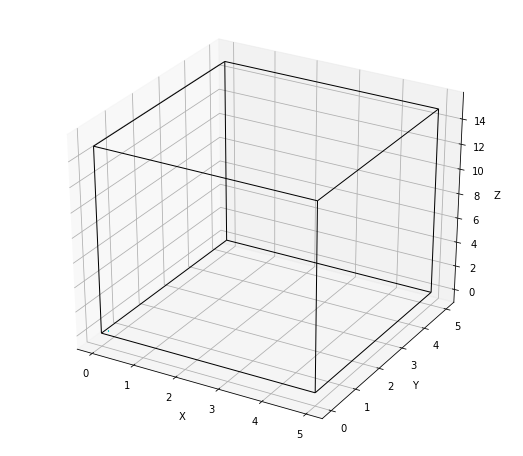

In [66]:
source = ParticleSourceConf("emit_single_particle", Box((.1, .1, .1), (.01, .01, .01)), 1, 0,
                           (6e-19, 6e-19, 1.77e-18), 0., 4.8e-10, 9.8e-28)
print(repr(source))
print(source)
Visualizer3d().visualize([mesh, source]) # small dot near (0, 0, 0) because mesh is so big

Next section is boundary conditions. 
In a free space, potentials on each boundary should be equal. 
It is possible to simply set them to zero.

In [67]:
boundary_sec = """
[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + boundary_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0



In [68]:
boundary_conditions = BoundaryConditionsConf(0)
print(repr(boundary_conditions))
print(boundary_conditions)

BoundaryConditionsConf(right=0.0, left=0.0, bottom=0.0, top=0.0, near=0.0, far=0.0)
### BoundaryConditionsConf:
right = 0.0
left = 0.0
bottom = 0.0
top = 0.0
near = 0.0
far = 0.0


Particle interaction model allows to choose between noninteracting particles, particle interacting with binary forces and PIC method. Since there is only one particle, there is no need to use PIC, and noninteracting mode is enough. Moreover, PIC will lead to wrong results (because particle creates electric field that acts back on the particle). 

In [69]:
particle_interaction_model_sec = """
[ParticleInteractionModel]
particle_interaction_model = noninteracting
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + particle_interaction_model_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0

[ParticleInteractionModel]
particle_interaction_model = noninteracting



In [70]:
model = ParticleInteractionModelConf('noninteracting')
print(repr(model))
print(model)

ParticleInteractionModelConf(model='noninteracting')
### ParticleInteractionModelConf:
model = 'noninteracting'


The last step is to specify pattern for output file names. 
They will be of the form `single_particle_free_space_0001000.h5`, where `0001000` is a time step number.

In [71]:
output_sec = """
[OutputFilename]
output_filename_prefix = single_particle_free_space_
output_filename_suffix = .h5
"""

single_particle_in_free_space_conf = single_particle_in_free_space_conf + output_sec

print( single_particle_in_free_space_conf )


[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_particle]
box_x_left = 0.11
box_x_right = 0.1
box_y_bottom = 0.1
box_y_top = 0.11
box_z_near = 0.1
box_z_far = 0.11
initial_number_of_particles = 1
particles_to_generate_each_step = 0
mean_momentum_x = 6e-19
mean_momentum_y = 6e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28

[BoundaryConditions]
boundary_phi_right = 0.0
boundary_phi_left = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0

[ParticleInteractionModel]
particle_interaction_model = noninteracting

[OutputFilename]
output_filename_prefix = single_particle_free_space_
output_filename_suffix = .h5



To start the simulation, the config should saved into file and provided as an argument to the `ef.out`, e.g.:

```
ef.out ./single_particle_in_free_space_conf.ini
```

EfJupyter module provides a wrapper `EfRunner` to do this.  

In [72]:
file_conf = OutputFileConf('single_particle_free_space_', '.h5')
print(repr(file_conf))
print(file_conf)

OutputFileConf(prefix='single_particle_free_space_', suffix='.h5')
### OutputFileConf:
prefix = 'single_particle_free_space_'
suffix = '.h5'


You can check that config objects describe the same simulation:

### EfConf:
time_grid = TimeGridConf(total=6e-09, save_step=6e-12, step=6e-12)
spatial_mesh = SpatialMeshConf(size=array([ 5.,  5., 15.]), step=array([0.5, 0.5, 1.5]))
sources = [ParticleSourceConf(name='emit_single_particle', shape=Box(origin=array([0.1, 0.1, 0.1]), size=array([0.01, 0.01, 0.01])), initial_particles=1, particles_to_generate_each_step=0, momentum=array([6.00e-19, 6.00e-19, 1.77e-18]), temperature=0.0, charge=4.8e-10, mass=9.8e-28)]
inner_regions = []
output_file = OutputFileConf(prefix='single_particle_free_space_', suffix='.h5')
boundary_conditions = BoundaryConditionsConf(right=0.0, left=0.0, bottom=0.0, top=0.0, near=0.0, far=0.0)
particle_interaction_model = ParticleInteractionModelConf(model='noninteracting')
external_fields = []
[TimeGrid]
total_time = 6e-09
time_save_step = 6e-12
time_step_size = 6e-12

[SpatialMesh]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 15.0
grid_z_step = 1.5

[ParticleSourceBox.emit_single_partic

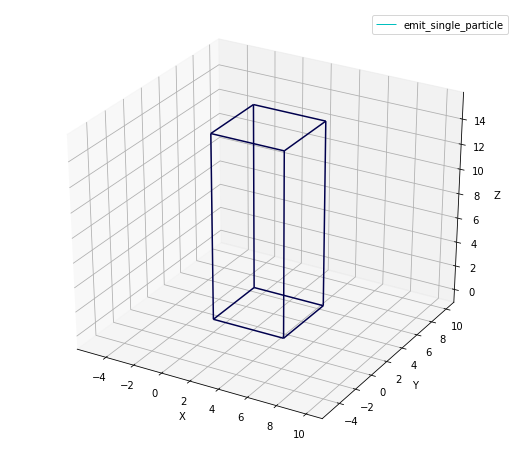

In [85]:
efconf = EfConf(timegrid, mesh, [source], [], file_conf, boundary_conditions, model)
print(efconf)
print(efconf.export_to_string())
assert repr(EfConf.from_string(single_particle_in_free_space_conf)) == repr(efconf)
conf.visualize_all(Visualizer3d())

To run outside Jupyter just save the config file

-  with any text editor
-  or with `efconf.export_to_file()`

Run `ef config.ini` in the directory where you want simulation to run and save results.

To run in python from Jupyter:

In [86]:
# if you start from .ini
# efconf = EfConf.from_fname('config.ini')
domain = efconf.make()
domain.start_pic_simulation()


Writing step 0 to file single_particle_free_space_0000000.h5
Time step from 0 to 1 of 1000
Writing step 1 to file single_particle_free_space_0000001.h5
Time step from 1 to 2 of 1000
Writing step 2 to file single_particle_free_space_0000002.h5
Time step from 2 to 3 of 1000
Writing step 3 to file single_particle_free_space_0000003.h5
Time step from 3 to 4 of 1000
Writing step 4 to file single_particle_free_space_0000004.h5
Time step from 4 to 5 of 1000
Writing step 5 to file single_particle_free_space_0000005.h5
Time step from 5 to 6 of 1000
Writing step 6 to file single_particle_free_space_0000006.h5
Time step from 6 to 7 of 1000
Writing step 7 to file single_particle_free_space_0000007.h5
Time step from 7 to 8 of 1000
Writing step 8 to file single_particle_free_space_0000008.h5
Time step from 8 to 9 of 1000
Writing step 9 to file single_particle_free_space_0000009.h5
Time step from 9 to 10 of 1000
Writing step 10 to file single_particle_free_space_0000010.h5
Time step from 10 to 11 of 

Time step from 98 to 99 of 1000
Writing step 99 to file single_particle_free_space_0000099.h5
Time step from 99 to 100 of 1000
Writing step 100 to file single_particle_free_space_0000100.h5
Time step from 100 to 101 of 1000
Writing step 101 to file single_particle_free_space_0000101.h5
Time step from 101 to 102 of 1000
Writing step 102 to file single_particle_free_space_0000102.h5
Time step from 102 to 103 of 1000
Writing step 103 to file single_particle_free_space_0000103.h5
Time step from 103 to 104 of 1000
Writing step 104 to file single_particle_free_space_0000104.h5
Time step from 104 to 105 of 1000
Writing step 105 to file single_particle_free_space_0000105.h5
Time step from 105 to 106 of 1000
Writing step 106 to file single_particle_free_space_0000106.h5
Time step from 106 to 107 of 1000
Writing step 107 to file single_particle_free_space_0000107.h5
Time step from 107 to 108 of 1000
Writing step 108 to file single_particle_free_space_0000108.h5
Time step from 108 to 109 of 1000


Time step from 199 to 200 of 1000
Writing step 200 to file single_particle_free_space_0000200.h5
Time step from 200 to 201 of 1000
Writing step 201 to file single_particle_free_space_0000201.h5
Time step from 201 to 202 of 1000
Writing step 202 to file single_particle_free_space_0000202.h5
Time step from 202 to 203 of 1000
Writing step 203 to file single_particle_free_space_0000203.h5
Time step from 203 to 204 of 1000
Writing step 204 to file single_particle_free_space_0000204.h5
Time step from 204 to 205 of 1000
Writing step 205 to file single_particle_free_space_0000205.h5
Time step from 205 to 206 of 1000
Writing step 206 to file single_particle_free_space_0000206.h5
Time step from 206 to 207 of 1000
Writing step 207 to file single_particle_free_space_0000207.h5
Time step from 207 to 208 of 1000
Writing step 208 to file single_particle_free_space_0000208.h5
Time step from 208 to 209 of 1000
Writing step 209 to file single_particle_free_space_0000209.h5
Time step from 209 to 210 of 1

Time step from 300 to 301 of 1000
Writing step 301 to file single_particle_free_space_0000301.h5
Time step from 301 to 302 of 1000
Writing step 302 to file single_particle_free_space_0000302.h5
Time step from 302 to 303 of 1000
Writing step 303 to file single_particle_free_space_0000303.h5
Time step from 303 to 304 of 1000
Writing step 304 to file single_particle_free_space_0000304.h5
Time step from 304 to 305 of 1000
Writing step 305 to file single_particle_free_space_0000305.h5
Time step from 305 to 306 of 1000
Writing step 306 to file single_particle_free_space_0000306.h5
Time step from 306 to 307 of 1000
Writing step 307 to file single_particle_free_space_0000307.h5
Time step from 307 to 308 of 1000
Writing step 308 to file single_particle_free_space_0000308.h5
Time step from 308 to 309 of 1000
Writing step 309 to file single_particle_free_space_0000309.h5
Time step from 309 to 310 of 1000
Writing step 310 to file single_particle_free_space_0000310.h5
Time step from 310 to 311 of 1

Time step from 396 to 397 of 1000
Writing step 397 to file single_particle_free_space_0000397.h5
Time step from 397 to 398 of 1000
Writing step 398 to file single_particle_free_space_0000398.h5
Time step from 398 to 399 of 1000
Writing step 399 to file single_particle_free_space_0000399.h5
Time step from 399 to 400 of 1000
Writing step 400 to file single_particle_free_space_0000400.h5
Time step from 400 to 401 of 1000
Writing step 401 to file single_particle_free_space_0000401.h5
Time step from 401 to 402 of 1000
Writing step 402 to file single_particle_free_space_0000402.h5
Time step from 402 to 403 of 1000
Writing step 403 to file single_particle_free_space_0000403.h5
Time step from 403 to 404 of 1000
Writing step 404 to file single_particle_free_space_0000404.h5
Time step from 404 to 405 of 1000
Writing step 405 to file single_particle_free_space_0000405.h5
Time step from 405 to 406 of 1000
Writing step 406 to file single_particle_free_space_0000406.h5
Time step from 406 to 407 of 1

Writing step 490 to file single_particle_free_space_0000490.h5
Time step from 490 to 491 of 1000
Writing step 491 to file single_particle_free_space_0000491.h5
Time step from 491 to 492 of 1000
Writing step 492 to file single_particle_free_space_0000492.h5
Time step from 492 to 493 of 1000
Writing step 493 to file single_particle_free_space_0000493.h5
Time step from 493 to 494 of 1000
Writing step 494 to file single_particle_free_space_0000494.h5
Time step from 494 to 495 of 1000
Writing step 495 to file single_particle_free_space_0000495.h5
Time step from 495 to 496 of 1000
Writing step 496 to file single_particle_free_space_0000496.h5
Time step from 496 to 497 of 1000
Writing step 497 to file single_particle_free_space_0000497.h5
Time step from 497 to 498 of 1000
Writing step 498 to file single_particle_free_space_0000498.h5
Time step from 498 to 499 of 1000
Writing step 499 to file single_particle_free_space_0000499.h5
Time step from 499 to 500 of 1000
Writing step 500 to file singl

Time step from 585 to 586 of 1000
Writing step 586 to file single_particle_free_space_0000586.h5
Time step from 586 to 587 of 1000
Writing step 587 to file single_particle_free_space_0000587.h5
Time step from 587 to 588 of 1000
Writing step 588 to file single_particle_free_space_0000588.h5
Time step from 588 to 589 of 1000
Writing step 589 to file single_particle_free_space_0000589.h5
Time step from 589 to 590 of 1000
Writing step 590 to file single_particle_free_space_0000590.h5
Time step from 590 to 591 of 1000
Writing step 591 to file single_particle_free_space_0000591.h5
Time step from 591 to 592 of 1000
Writing step 592 to file single_particle_free_space_0000592.h5
Time step from 592 to 593 of 1000
Writing step 593 to file single_particle_free_space_0000593.h5
Time step from 593 to 594 of 1000
Writing step 594 to file single_particle_free_space_0000594.h5
Time step from 594 to 595 of 1000
Writing step 595 to file single_particle_free_space_0000595.h5
Time step from 595 to 596 of 1

Time step from 685 to 686 of 1000
Writing step 686 to file single_particle_free_space_0000686.h5
Time step from 686 to 687 of 1000
Writing step 687 to file single_particle_free_space_0000687.h5
Time step from 687 to 688 of 1000
Writing step 688 to file single_particle_free_space_0000688.h5
Time step from 688 to 689 of 1000
Writing step 689 to file single_particle_free_space_0000689.h5
Time step from 689 to 690 of 1000
Writing step 690 to file single_particle_free_space_0000690.h5
Time step from 690 to 691 of 1000
Writing step 691 to file single_particle_free_space_0000691.h5
Time step from 691 to 692 of 1000
Writing step 692 to file single_particle_free_space_0000692.h5
Time step from 692 to 693 of 1000
Writing step 693 to file single_particle_free_space_0000693.h5
Time step from 693 to 694 of 1000
Writing step 694 to file single_particle_free_space_0000694.h5
Time step from 694 to 695 of 1000
Writing step 695 to file single_particle_free_space_0000695.h5
Time step from 695 to 696 of 1

Time step from 785 to 786 of 1000
Writing step 786 to file single_particle_free_space_0000786.h5
Time step from 786 to 787 of 1000
Writing step 787 to file single_particle_free_space_0000787.h5
Time step from 787 to 788 of 1000
Writing step 788 to file single_particle_free_space_0000788.h5
Time step from 788 to 789 of 1000
Writing step 789 to file single_particle_free_space_0000789.h5
Time step from 789 to 790 of 1000
Writing step 790 to file single_particle_free_space_0000790.h5
Time step from 790 to 791 of 1000
Writing step 791 to file single_particle_free_space_0000791.h5
Time step from 791 to 792 of 1000
Writing step 792 to file single_particle_free_space_0000792.h5
Time step from 792 to 793 of 1000
Writing step 793 to file single_particle_free_space_0000793.h5
Time step from 793 to 794 of 1000
Writing step 794 to file single_particle_free_space_0000794.h5
Time step from 794 to 795 of 1000
Writing step 795 to file single_particle_free_space_0000795.h5
Time step from 795 to 796 of 1

Writing step 890 to file single_particle_free_space_0000890.h5
Time step from 890 to 891 of 1000
Writing step 891 to file single_particle_free_space_0000891.h5
Time step from 891 to 892 of 1000
Writing step 892 to file single_particle_free_space_0000892.h5
Time step from 892 to 893 of 1000
Writing step 893 to file single_particle_free_space_0000893.h5
Time step from 893 to 894 of 1000
Writing step 894 to file single_particle_free_space_0000894.h5
Time step from 894 to 895 of 1000
Writing step 895 to file single_particle_free_space_0000895.h5
Time step from 895 to 896 of 1000
Writing step 896 to file single_particle_free_space_0000896.h5
Time step from 896 to 897 of 1000
Writing step 897 to file single_particle_free_space_0000897.h5
Time step from 897 to 898 of 1000
Writing step 898 to file single_particle_free_space_0000898.h5
Time step from 898 to 899 of 1000
Writing step 899 to file single_particle_free_space_0000899.h5
Time step from 899 to 900 of 1000
Writing step 900 to file singl

Time step from 998 to 999 of 1000
Writing step 999 to file single_particle_free_space_0000999.h5
Time step from 999 to 1000 of 1000
Writing step 1000 to file single_particle_free_space_0001000.h5


To run outside python (for example, C++ ef):

In [ ]:
from ef.util.runner import EfRunner
EfRunner(efconf, './ef.out')

After the simulation finishes, a bunch of `*.h5` files emerge in the directory.

In [10]:
!ls

2d.png
3d.png
estimates.py
kin_en.png
plot.py
run_example.sh
single_particle_free_space_0000000.h5
single_particle_free_space_0000001.h5
single_particle_free_space_0000002.h5
single_particle_free_space_0000003.h5
single_particle_free_space_0000004.h5
single_particle_free_space_0000005.h5
single_particle_free_space_0000006.h5
single_particle_free_space_0000007.h5
single_particle_free_space_0000008.h5
single_particle_free_space_0000009.h5
single_particle_free_space_0000010.h5
single_particle_free_space_0000011.h5
single_particle_free_space_0000012.h5
single_particle_free_space_0000013.h5
single_particle_free_space_0000014.h5
single_particle_free_space_0000015.h5
single_particle_free_space_0000016.h5
single_particle_free_space_0000017.h5
single_particle_free_space_0000018.h5
single_particle_free_space_0000019.h5
single_particle_free_space_0000020.h5
single_particle_free_space_0000021.h5
single_particle_free_space_0000022.h5
single_particle_free_space_0000023.h5
single_particle_free_space_

To open these files and glance over the results, an [Hdfview](https://support.hdfgroup.org/products/java/hdfview/) is a convenient tool.
In this simulation, two places are of interest: `current time` and particle position
and momentum at this time moment:

<p align="center">
<img src="https://github.com/epicf/ef/blob/dev/doc/figs/single_particle_in_free_space/hdfview_results.png?raw=true" alt="hdfview screenshot" width="600"/>
</p>

Each created `h5`-file corresponds to a different time step. 
If we were able to extract time, position and momentum of the particle from each file, we could have obtained numerical trajectory, which could be compared to the analytical one. 

Data extraction and plotting are accomplished by the accompanying [`plot.py`](https://github.com/epicf/ef/blob/master/examples/single_particle_in_free_space/plot.py) python script (see below). Its constituent parts are described further. The script produces a 3d plot and side views of the numerical and analytical trajectories. Besides, kinetic energies are compared.

In [3]:
import os, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points( num )
    plot_trajectories( num , an )

def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()    

    num_trajectory = []
    for f in out_files:
        num_trajectory.append( extract_time_pos_mom( f ) )    

    num_trajectory = remove_empty_and_sort_by_time( num_trajectory )
    num_trajectory = np.array( num_trajectory, 
                               dtype=[('t','float'),
                                      ('x','float'), ('y','float'), ('z','float'),
                                      ('px','float'), ('py','float'), ('pz','float') ] )
    return( num_trajectory )

def remove_empty_and_sort_by_time( num_trajectory ):
    removed_empty = [ x for x in num_trajectory if x ]
    sorted_by_time = sorted( removed_empty, key = lambda x: x[0] )
    return ( sorted_by_time )

def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("single_particle_free_space_[0-9]*.h5"):
        h5files.append( file )
    return h5files

def extract_time_pos_mom( h5file ):
    h5 = h5py.File( h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"]
    t_pos_mom = ()
    if ( len(h5["/ParticleSources/emit_single_particle"]) > 0 ):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return( t_pos_mom )

def eval_an_trajectory_at_num_time_points( num_trajectory ):
    global particle_mass
    particle_mass, x0, y0, z0, px0, py0, pz0 =  get_mass_and_initial_pos_and_mom()

    an_trajectory = np.empty_like( num_trajectory )
    for i, t in enumerate( num_trajectory['t'] ):
        x, y, z = coords( particle_mass, t, x0, y0, z0, px0, py0, pz0 )
        px, py, pz = momenta( t, px0, py0, pz0 )
        an_trajectory[i] = ( t, x, y ,z, px, py, pz )

    return( an_trajectory )

def get_mass_and_initial_pos_and_mom():
    initial_out_file = "single_particle_free_space_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"]
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    h5.close()
    return( m, x0, y0, z0, px0, py0, pz0 )

def momenta( t, px0, py0, pz0 ):    
    px = px0
    py = py0
    pz = pz0
    return ( px, py, pz )

def coords( m, t, x0, y0, z0, px0, py0, pz0 ):
    x = x0 + px0 / m * t
    y = y0 + py0 / m * t
    z = z0 + pz0 / m * t
    return ( x, y, z )

def plot_trajectories( num , an ):
    plot_3d( num, an )
    plot_2d( num, an )
    plot_kin_en( num , an )

def plot_3d( num, an ):
    fig = plt.figure()
    ax = fig.gca( projection='3d' )
    ax.plot( num['x'], num['z'], num['y'], 'b.', markersize = 12, label = "Num" )
    ax.plot( an['x'], an['z'], an['y'],  'g-', linewidth = 3, label = "An" )
    ax.set_xlabel('X [cm]') 
    ax.set_ylabel('Z [cm]') 
    ax.set_zlabel('Y [cm]')
    plt.legend( loc = 'upper left', title="3d" )
    #print( 'Saving 3d trajectory plot to "3d.png"' )
    #plt.savefig('3d.png')
    plt.show()

def plot_2d( num, an ):
    plt.figure( figsize=( 16, 6 ) )
    plt.subplots_adjust( left = None, bottom = None,
                         right = None, top = None,
                         wspace = 0.4, hspace = None )
    #XY
    ax = plt.subplot(131)
    plt.plot( num['x'], num['y'],
              linestyle='', marker='o',
              label = "Num" )
    plt.plot( an['x'], an['y'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('X [cm]') 
    ax.set_ylabel('Y [cm]') 
    plt.legend( loc = 'upper left', title="XY" )
    #ZX
    ax = plt.subplot(132)
    plt.plot( num['z'], num['x'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['z'], an['x'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('Z [cm]') 
    ax.set_ylabel('X [cm]') 
    plt.legend( loc = 'upper left', title="ZX" )
    #ZY
    ax = plt.subplot(133)
    plt.plot( num['z'], num['y'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['z'], an['y'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    ax.set_xlabel('Z [cm]') 
    ax.set_ylabel('Y [cm]') 
    plt.legend( loc = 'upper left', title="ZY" )
    #print( 'Saving 2d trajectory projection plots to "2d.png"' )
    #plt.savefig('2d.png')
    plt.show()
    
def plot_kin_en( num , an ):
    global particle_mass
    E_num = ( num['px']**2 + num['py']**2 + num['pz']**2 ) / ( 2 * particle_mass )
    E_an = ( an['px']**2 + an['py']**2 + an['pz']**2 ) / ( 2 * particle_mass )
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel( "t [s]" )
    axes.set_ylabel( "E [erg]" )
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot( t, E_num, 'o' )
    line.set_label( "Num" )
    line, = plt.plot( t, E_an, ls = 'solid', lw = 3 )
    line.set_label( "An" )
    plt.legend( loc = 'upper right' )
    #print( 'Saving kinetic energy comparison plot to "kin_en.png"' )
    #plt.savefig('kin_en.png')
    plt.show()


main()

OSError: Unable to open file (unable to open file: name = 'single_particle_free_space_0000000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

It can be seen, that numerical trajectory (points) coincides with the analytical (line) and that the energy is conserved during the simulation.

### Plotting script

The `main` function of the script does exactly what is described above: extracts numerical trajectory from the output files, evaluates analytical trajectory at the extracted time points and plots both numerical and analytical trajectories on the same axes.

```
def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points( num )
    plot_trajectories( num , an )
```

It uses [h5py](http://www.h5py.org/) library to read from h5 files, [numpy](http://www.numpy.org/) to simplify working with arrays and [matplotlib](https://matplotlib.org/) to perform plotting of the trajectory. 

```
import os, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
```

Let's examine the function to obtain the numerical trajectory:

```
def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()                           # (*1)

    num_trajectory = []
    for f in out_files:
        num_trajectory.append( extract_time_pos_mom( f ) )           # (*2)  

    num_trajectory = remove_empty_and_sort_by_time( num_trajectory ) # (*3)
    num_trajectory = np.array( num_trajectory,                       # (*4)
                               dtype=[('t','float'),
                                      ('x','float'), ('y','float'), ('z','float'),
                                      ('px','float'), ('py','float'),('pz','float')])
    return( num_trajectory )
```

(\*1): To extract data, first we find all `*.h5` files in the current directory.  
(\*2): Then the script iterates over them and extracts a relevant data from each one.  
(\*3): In the end of this process, `num_trajectory` array contains positions and velocities of particle at different
time steps. In is convenient to sort it over time values.  
(\*4): After the previous step the numerical trajectory is in a format of a list of tuples:
`[ (t, x, y, z, px, py, pz), ..... ]` . It is convenient to convert it into one of the `np.array` types to simplify further manipulations with it.  

For analytical trajectory we need the initial position and momentum.
They can be extracted from the first h5-file:

```
def get_mass_and_initial_pos_and_mom():
    initial_out_file = "single_particle_free_space_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"][0]
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    h5.close()
    return( m, x0, y0, z0, px0, py0, pz0 )
```

With this function, the analytical trajectory can be computed at the same 
time points as the numerical one:

```
def eval_an_trajectory_at_num_time_points( num_trajectory ):
    global particle_mass
    particle_mass, x0, y0, z0, px0, py0, pz0 =  get_mass_and_initial_pos_and_mom()
    #
    an_trajectory = np.empty_like( num_trajectory )
    for i, t in enumerate( num_trajectory['t'] ):
        x, y, z = coords( particle_mass, t, x0, y0, z0, px0, py0, pz0 )
        px, py, pz = momenta( t, px0, py0, pz0 )
        an_trajectory[i] = ( t, x, y ,z, px, py, pz )
    #
    return( an_trajectory )
```

Finally, both numerical and analytical trajectories are plotted in 3d and side views. 
Kinetic energies are also compared.

```
def plot_trajectories( num , an ):
    plot_3d( num, an )
    plot_2d( num, an )
    plot_kin_en( num , an )
```